In [2]:
!nvidia-smi

Sat Oct  7 10:16:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P4              11W /  55W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [4]:
from transformations import train_transforms,test_transforms

In [5]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [6]:
# ALbumentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

cifar = CIFAR10DataLoader()
train_loader,test_loader = cifar.get_loader(train_dataset,test_dataset)

In [7]:
cifar = CIFAR10DataLoader()
simple_train_loader , simple_test_loader = cifar.get_loader(
    CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False),
    CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
)

# Resnet like Architecture

In [7]:
# We used this Squeeze-Expand Network before
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.dp_rate = 0.2

        self.c1 = ConvLayer(inc=3,outc=16,s=1,k=3,p=1,d=1,dp_rate=self.dp_rate)
        self.c2 = ConvLayer(inc=16,outc=16,s=1,p=1,k=3,d=1,dp_rate=self.dp_rate)
        self.c3 = ConvLayer(inc=16,outc=32,s=2,p=1,d=1,k=3,dp_rate=self.dp_rate)
        
        self.c4 = ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c5 = ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c6 = ConvLayer(inc=32,outc=32,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate)

        self.c7 = ConvLayer(inc=32,outc=60,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c8 = ConvLayer(inc=60,outc=60,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c9 = nn.Sequential(
            nn.Conv2d(in_channels=60,out_channels=60,kernel_size=3,stride=2,dilation=1,padding=1,bias=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.c10 = nn.Conv2d(60,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        
        x = x+self.c4(x)
        x = x+self.c5(x)
        x = self.c6(x)

        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)

        x = self.gap(x)
        x = self.c10(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [8]:
simple_model = Net1().to(device)
# summary(simple_model,(3,32,32))

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(simple_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, train_loader, optimizer, criterion, device)
tester = Tester(simple_model, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.2 | Loss = 2.05 | Batch = 390 | Accuracy = 22.65: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.31it/s]


Test set: Average loss: 0.0147, Accuracy: 3008/10000 (30.08%)


EPOCH = 2 | LR = 0.2 | Loss = 1.89 | Batch = 390 | Accuracy = 29.66: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.67it/s]


Test set: Average loss: 0.0130, Accuracy: 3822/10000 (38.22%)


EPOCH = 3 | LR = 0.2 | Loss = 1.87 | Batch = 390 | Accuracy = 33.06: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.41it/s]


Test set: Average loss: 0.0130, Accuracy: 4025/10000 (40.25%)


EPOCH = 4 | LR = 0.2 | Loss = 1.87 | Batch = 390 | Accuracy = 34.24: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.92it/s]


Test set: Average loss: 0.0125, Accuracy: 4148/10000 (41.48%)


EPOCH = 5 | LR = 0.2 | Loss = 1.90 | Batch = 390 | Accuracy = 35.92: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.78it/s]


Test set: Average loss: 0.0120, Accuracy: 4513/10000 (45.13%)


EPOCH = 6 | LR = 0.2 | Loss = 1.69 | Batch = 390 | Accuracy = 37.03: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.21it/s]


Test set: Average loss: 0.0114, Accuracy: 4665/10000 (46.65%)


EPOCH = 7 | LR = 0.2 | Loss = 1.73 | Batch = 390 | Accuracy = 38.12: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.68it/s]


Test set: Average loss: 0.0113, Accuracy: 4689/10000 (46.89%)


EPOCH = 8 | LR = 0.2 | Loss = 1.67 | Batch = 390 | Accuracy = 38.59: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.44it/s]


Test set: Average loss: 0.0112, Accuracy: 4689/10000 (46.89%)


EPOCH = 9 | LR = 0.2 | Loss = 1.70 | Batch = 390 | Accuracy = 39.45: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.88it/s]


Test set: Average loss: 0.0112, Accuracy: 4645/10000 (46.45%)


EPOCH = 10 | LR = 0.2 | Loss = 1.49 | Batch = 390 | Accuracy = 39.78: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.92it/s]


Test set: Average loss: 0.0111, Accuracy: 4671/10000 (46.71%)


EPOCH = 11 | LR = 0.2 | Loss = 1.47 | Batch = 390 | Accuracy = 40.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.43it/s]


Test set: Average loss: 0.0109, Accuracy: 4909/10000 (49.09%)


EPOCH = 12 | LR = 0.2 | Loss = 1.68 | Batch = 390 | Accuracy = 40.76: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.32it/s]


Test set: Average loss: 0.0108, Accuracy: 4961/10000 (49.61%)


EPOCH = 13 | LR = 0.2 | Loss = 1.79 | Batch = 390 | Accuracy = 41.27: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.92it/s]


Test set: Average loss: 0.0107, Accuracy: 4872/10000 (48.72%)


EPOCH = 14 | LR = 0.2 | Loss = 1.65 | Batch = 390 | Accuracy = 41.67: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.83it/s]


Test set: Average loss: 0.0109, Accuracy: 4951/10000 (49.51%)


EPOCH = 15 | LR = 0.2 | Loss = 1.53 | Batch = 390 | Accuracy = 42.04: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.70it/s]


Test set: Average loss: 0.0106, Accuracy: 5084/10000 (50.84%)


EPOCH = 16 | LR = 0.2 | Loss = 1.51 | Batch = 390 | Accuracy = 42.81: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.36it/s]


Test set: Average loss: 0.0104, Accuracy: 5207/10000 (52.07%)


EPOCH = 17 | LR = 0.2 | Loss = 1.37 | Batch = 390 | Accuracy = 42.83: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.81it/s]


Test set: Average loss: 0.0103, Accuracy: 5212/10000 (52.12%)


EPOCH = 18 | LR = 0.2 | Loss = 1.66 | Batch = 390 | Accuracy = 43.29: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.53it/s]


Test set: Average loss: 0.0101, Accuracy: 5302/10000 (53.02%)


EPOCH = 19 | LR = 0.2 | Loss = 1.44 | Batch = 390 | Accuracy = 43.68: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.20it/s]


Test set: Average loss: 0.0098, Accuracy: 5448/10000 (54.48%)


EPOCH = 20 | LR = 0.2 | Loss = 1.63 | Batch = 390 | Accuracy = 43.58: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.17it/s]


Test set: Average loss: 0.0101, Accuracy: 5435/10000 (54.35%)


EPOCH = 21 | LR = 0.2 | Loss = 1.59 | Batch = 390 | Accuracy = 44.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.26it/s]


Test set: Average loss: 0.0101, Accuracy: 5352/10000 (53.52%)


EPOCH = 22 | LR = 0.2 | Loss = 1.58 | Batch = 390 | Accuracy = 44.94: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.66it/s]


Test set: Average loss: 0.0098, Accuracy: 5432/10000 (54.32%)


EPOCH = 23 | LR = 0.2 | Loss = 1.60 | Batch = 390 | Accuracy = 45.20: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.92it/s]


Test set: Average loss: 0.0098, Accuracy: 5405/10000 (54.05%)


EPOCH = 24 | LR = 0.2 | Loss = 1.54 | Batch = 390 | Accuracy = 45.16: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.89it/s]


Test set: Average loss: 0.0096, Accuracy: 5577/10000 (55.77%)


EPOCH = 25 | LR = 0.2 | Loss = 1.55 | Batch = 390 | Accuracy = 45.53: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.69it/s]


Test set: Average loss: 0.0097, Accuracy: 5510/10000 (55.10%)


EPOCH = 26 | LR = 0.2 | Loss = 1.67 | Batch = 390 | Accuracy = 45.76: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.21it/s]


Test set: Average loss: 0.0093, Accuracy: 5656/10000 (56.56%)


EPOCH = 27 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 45.88: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.22it/s]


Test set: Average loss: 0.0094, Accuracy: 5671/10000 (56.71%)


EPOCH = 28 | LR = 0.2 | Loss = 1.59 | Batch = 390 | Accuracy = 46.06: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.12it/s]


Test set: Average loss: 0.0095, Accuracy: 5643/10000 (56.43%)


EPOCH = 29 | LR = 0.2 | Loss = 1.37 | Batch = 390 | Accuracy = 46.33: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.70it/s]


Test set: Average loss: 0.0094, Accuracy: 5708/10000 (57.08%)


EPOCH = 30 | LR = 0.2 | Loss = 1.38 | Batch = 390 | Accuracy = 46.68: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.38it/s]


Test set: Average loss: 0.0094, Accuracy: 5744/10000 (57.44%)


EPOCH = 31 | LR = 0.2 | Loss = 1.27 | Batch = 390 | Accuracy = 47.11: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.15it/s]


Test set: Average loss: 0.0090, Accuracy: 5901/10000 (59.01%)


EPOCH = 32 | LR = 0.2 | Loss = 1.47 | Batch = 390 | Accuracy = 47.28: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.02it/s]


Test set: Average loss: 0.0091, Accuracy: 5856/10000 (58.56%)


EPOCH = 33 | LR = 0.2 | Loss = 1.43 | Batch = 390 | Accuracy = 47.36: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.43it/s]


Test set: Average loss: 0.0092, Accuracy: 5738/10000 (57.38%)


EPOCH = 34 | LR = 0.2 | Loss = 1.34 | Batch = 390 | Accuracy = 47.65: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.71it/s]


Test set: Average loss: 0.0090, Accuracy: 5985/10000 (59.85%)


EPOCH = 35 | LR = 0.2 | Loss = 1.56 | Batch = 390 | Accuracy = 47.76: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.72it/s]


Test set: Average loss: 0.0091, Accuracy: 5907/10000 (59.07%)


EPOCH = 36 | LR = 0.2 | Loss = 1.27 | Batch = 390 | Accuracy = 47.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.00it/s]


Test set: Average loss: 0.0090, Accuracy: 5859/10000 (58.59%)


EPOCH = 37 | LR = 0.2 | Loss = 1.35 | Batch = 390 | Accuracy = 47.82: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.00it/s]


Test set: Average loss: 0.0087, Accuracy: 6067/10000 (60.67%)


EPOCH = 38 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 48.33: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.22it/s]


Test set: Average loss: 0.0092, Accuracy: 5822/10000 (58.22%)


EPOCH = 39 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 48.25: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.68it/s]


Test set: Average loss: 0.0086, Accuracy: 6072/10000 (60.72%)


EPOCH = 40 | LR = 0.2 | Loss = 1.23 | Batch = 390 | Accuracy = 48.21: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.62it/s]


Test set: Average loss: 0.0087, Accuracy: 6104/10000 (61.04%)


EPOCH = 41 | LR = 0.2 | Loss = 1.23 | Batch = 390 | Accuracy = 48.74: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.73it/s]


Test set: Average loss: 0.0091, Accuracy: 5819/10000 (58.19%)


EPOCH = 42 | LR = 0.2 | Loss = 1.44 | Batch = 390 | Accuracy = 49.09: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.66it/s]


Test set: Average loss: 0.0087, Accuracy: 5983/10000 (59.83%)


EPOCH = 43 | LR = 0.2 | Loss = 1.51 | Batch = 390 | Accuracy = 48.82: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.78it/s]


Test set: Average loss: 0.0085, Accuracy: 6134/10000 (61.34%)


EPOCH = 44 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 49.16: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.59it/s]


Test set: Average loss: 0.0085, Accuracy: 6079/10000 (60.79%)


EPOCH = 45 | LR = 0.2 | Loss = 1.23 | Batch = 390 | Accuracy = 50.01: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.31it/s]


Test set: Average loss: 0.0085, Accuracy: 6135/10000 (61.35%)


EPOCH = 46 | LR = 0.2 | Loss = 1.49 | Batch = 390 | Accuracy = 49.46: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.09it/s]


Test set: Average loss: 0.0086, Accuracy: 6098/10000 (60.98%)


EPOCH = 47 | LR = 0.2 | Loss = 1.30 | Batch = 390 | Accuracy = 49.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.93it/s]


Test set: Average loss: 0.0086, Accuracy: 6065/10000 (60.65%)


EPOCH = 48 | LR = 0.2 | Loss = 1.20 | Batch = 390 | Accuracy = 49.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.92it/s]


Test set: Average loss: 0.0083, Accuracy: 6246/10000 (62.46%)


EPOCH = 49 | LR = 0.2 | Loss = 1.32 | Batch = 390 | Accuracy = 50.12: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.76it/s]


Test set: Average loss: 0.0084, Accuracy: 6145/10000 (61.45%)


EPOCH = 50 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 49.92: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.29it/s]


Test set: Average loss: 0.0084, Accuracy: 6176/10000 (61.76%)


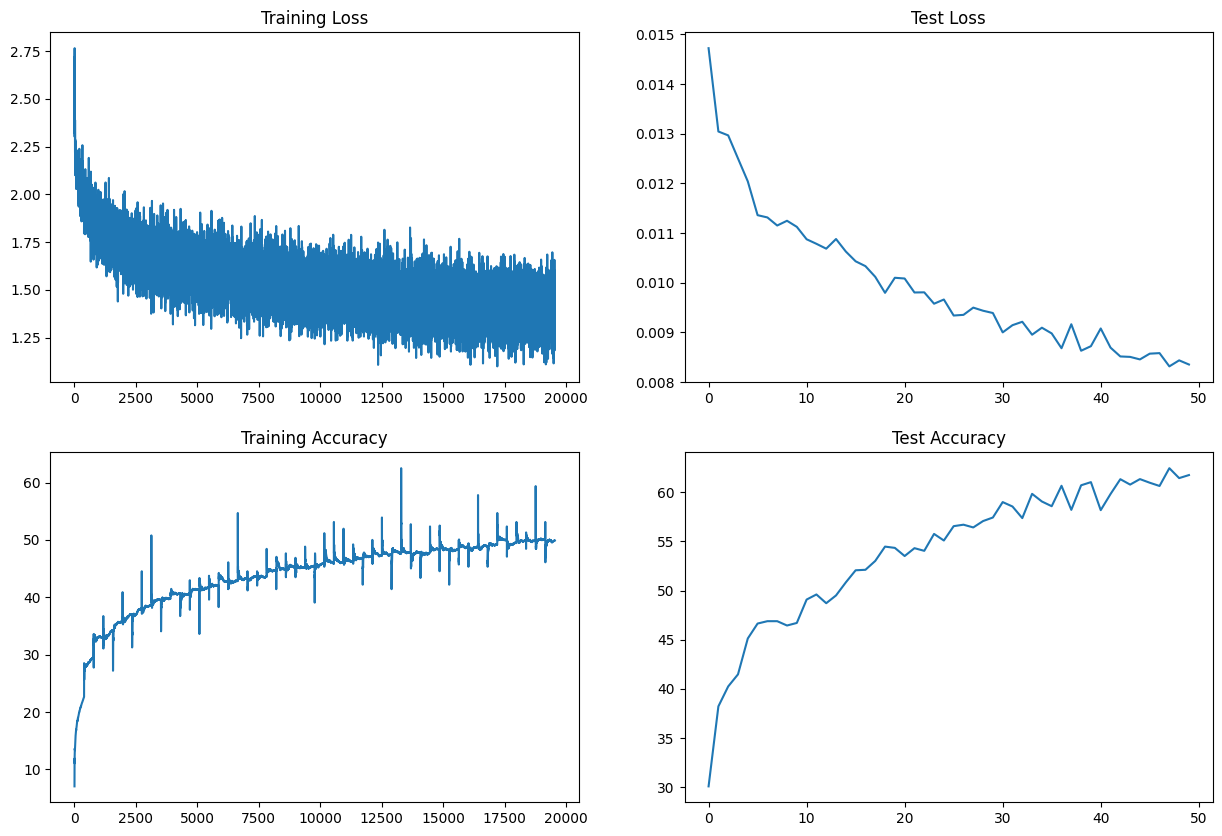

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [11]:
# We used this Squeeze-Expand Network before
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        self.dp_rate = 0.1

        self.c1 = ConvLayer(inc=3,outc=16,s=1,k=3,p=1,d=1,dp_rate=self.dp_rate)
        self.c2 = ConvLayer(inc=16,outc=16,s=1,p=1,k=3,d=1,dp_rate=self.dp_rate)
        self.c3 = ConvLayer(inc=16,outc=32,s=2,p=1,d=1,k=3,dp_rate=self.dp_rate)
        
        self.c4 = ConvLayer(inc=32,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c5 = ConvLayer(inc=40,outc=40,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c6 = ConvLayer(inc=40,outc=40,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate)

        self.c7 = ConvLayer(inc=40,outc=80,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c8 = ConvLayer(inc=80,outc=80,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate)
        self.c9 = nn.Sequential(
            nn.Conv2d(in_channels=80,out_channels=70,kernel_size=3,stride=2,dilation=1,padding=1,bias=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.c10 = nn.Conv2d(70,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        
        x = self.c4(x)
        x = x+self.c5(x)
        x = self.c6(x)

        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)

        x = self.gap(x)
        x = self.c10(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [12]:
model2 = Net2().to(device)
# summary(model2,(3,32,32))

In [13]:
prev_test_loss = float('inf')
model2 = Net2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2, train_loader, optimizer, criterion, device)
tester = Tester(model2, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model2.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.80 | Batch = 390 | Accuracy = 25.40: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.54it/s]


Test set: Average loss: 0.0132, Accuracy: 3777/10000 (37.77%)


EPOCH = 2 | LR = 0.1 | Loss = 1.58 | Batch = 390 | Accuracy = 34.72: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.18it/s]


Test set: Average loss: 0.0116, Accuracy: 4613/10000 (46.13%)


EPOCH = 3 | LR = 0.1 | Loss = 1.65 | Batch = 390 | Accuracy = 39.03: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.90it/s]


Test set: Average loss: 0.0111, Accuracy: 4735/10000 (47.35%)


EPOCH = 4 | LR = 0.1 | Loss = 1.65 | Batch = 390 | Accuracy = 41.49: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.08it/s]


Test set: Average loss: 0.0105, Accuracy: 5118/10000 (51.18%)


EPOCH = 5 | LR = 0.1 | Loss = 1.56 | Batch = 390 | Accuracy = 43.22: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.75it/s]


Test set: Average loss: 0.0102, Accuracy: 5300/10000 (53.00%)


EPOCH = 6 | LR = 0.1 | Loss = 1.41 | Batch = 390 | Accuracy = 45.77: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.56it/s]


Test set: Average loss: 0.0094, Accuracy: 5601/10000 (56.01%)


EPOCH = 7 | LR = 0.1 | Loss = 1.58 | Batch = 390 | Accuracy = 47.07: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.99it/s]


Test set: Average loss: 0.0093, Accuracy: 5753/10000 (57.53%)


EPOCH = 8 | LR = 0.1 | Loss = 1.39 | Batch = 390 | Accuracy = 48.88: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.80it/s]


Test set: Average loss: 0.0088, Accuracy: 5878/10000 (58.78%)


EPOCH = 9 | LR = 0.1 | Loss = 1.27 | Batch = 390 | Accuracy = 50.73: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.23it/s]


Test set: Average loss: 0.0085, Accuracy: 6085/10000 (60.85%)


EPOCH = 10 | LR = 0.1 | Loss = 1.33 | Batch = 390 | Accuracy = 51.65: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.80it/s]


Test set: Average loss: 0.0081, Accuracy: 6413/10000 (64.13%)


EPOCH = 11 | LR = 0.1 | Loss = 1.34 | Batch = 390 | Accuracy = 52.98: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.35it/s]


Test set: Average loss: 0.0086, Accuracy: 6100/10000 (61.00%)


EPOCH = 12 | LR = 0.1 | Loss = 1.11 | Batch = 390 | Accuracy = 54.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.65it/s]


Test set: Average loss: 0.0078, Accuracy: 6455/10000 (64.55%)


EPOCH = 13 | LR = 0.1 | Loss = 1.08 | Batch = 390 | Accuracy = 54.89: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 23.11it/s]


Test set: Average loss: 0.0073, Accuracy: 6735/10000 (67.35%)


EPOCH = 14 | LR = 0.1 | Loss = 1.07 | Batch = 390 | Accuracy = 55.70: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.85it/s]


Test set: Average loss: 0.0069, Accuracy: 6938/10000 (69.38%)


EPOCH = 15 | LR = 0.1 | Loss = 1.22 | Batch = 390 | Accuracy = 56.96: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.41it/s]


Test set: Average loss: 0.0075, Accuracy: 6595/10000 (65.95%)


EPOCH = 16 | LR = 0.1 | Loss = 1.24 | Batch = 390 | Accuracy = 57.28: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 0.0069, Accuracy: 6926/10000 (69.26%)


EPOCH = 17 | LR = 0.1 | Loss = 1.32 | Batch = 390 | Accuracy = 57.92: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.47it/s]


Test set: Average loss: 0.0066, Accuracy: 7058/10000 (70.58%)


EPOCH = 18 | LR = 0.1 | Loss = 1.14 | Batch = 390 | Accuracy = 58.88: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.51it/s]


Test set: Average loss: 0.0065, Accuracy: 7134/10000 (71.34%)


EPOCH = 19 | LR = 0.1 | Loss = 1.35 | Batch = 390 | Accuracy = 59.34: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.29it/s]


Test set: Average loss: 0.0067, Accuracy: 7065/10000 (70.65%)


EPOCH = 20 | LR = 0.1 | Loss = 1.29 | Batch = 390 | Accuracy = 59.89: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.29it/s]


Test set: Average loss: 0.0061, Accuracy: 7336/10000 (73.36%)


EPOCH = 21 | LR = 0.1 | Loss = 1.56 | Batch = 390 | Accuracy = 60.17: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.69it/s]


Test set: Average loss: 0.0063, Accuracy: 7252/10000 (72.52%)


EPOCH = 22 | LR = 0.1 | Loss = 1.00 | Batch = 390 | Accuracy = 60.64: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.75it/s]


Test set: Average loss: 0.0061, Accuracy: 7289/10000 (72.89%)


EPOCH = 23 | LR = 0.1 | Loss = 1.12 | Batch = 390 | Accuracy = 61.06: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.01it/s]


Test set: Average loss: 0.0060, Accuracy: 7328/10000 (73.28%)


EPOCH = 24 | LR = 0.1 | Loss = 1.13 | Batch = 390 | Accuracy = 61.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.01it/s]


Test set: Average loss: 0.0062, Accuracy: 7188/10000 (71.88%)


EPOCH = 25 | LR = 0.1 | Loss = 1.18 | Batch = 390 | Accuracy = 61.58: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.99it/s]


Test set: Average loss: 0.0061, Accuracy: 7261/10000 (72.61%)


EPOCH = 26 | LR = 0.1 | Loss = 1.12 | Batch = 390 | Accuracy = 62.00: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.22it/s]


Test set: Average loss: 0.0057, Accuracy: 7539/10000 (75.39%)


EPOCH = 27 | LR = 0.1 | Loss = 0.89 | Batch = 390 | Accuracy = 62.11: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.92it/s]


Test set: Average loss: 0.0055, Accuracy: 7552/10000 (75.52%)


EPOCH = 28 | LR = 0.1 | Loss = 1.24 | Batch = 390 | Accuracy = 62.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.77it/s]


Test set: Average loss: 0.0056, Accuracy: 7557/10000 (75.57%)


EPOCH = 29 | LR = 0.1 | Loss = 1.20 | Batch = 390 | Accuracy = 63.04: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.28it/s]


Test set: Average loss: 0.0059, Accuracy: 7382/10000 (73.82%)


EPOCH = 30 | LR = 0.1 | Loss = 1.09 | Batch = 390 | Accuracy = 62.96: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.56it/s]


Test set: Average loss: 0.0055, Accuracy: 7531/10000 (75.31%)


EPOCH = 31 | LR = 0.1 | Loss = 0.99 | Batch = 390 | Accuracy = 63.11: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.0054, Accuracy: 7599/10000 (75.99%)


EPOCH = 32 | LR = 0.1 | Loss = 0.83 | Batch = 390 | Accuracy = 63.70: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.19it/s]


Test set: Average loss: 0.0055, Accuracy: 7625/10000 (76.25%)


EPOCH = 33 | LR = 0.1 | Loss = 1.02 | Batch = 390 | Accuracy = 63.68: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.08it/s]


Test set: Average loss: 0.0056, Accuracy: 7527/10000 (75.27%)


EPOCH = 34 | LR = 0.1 | Loss = 0.91 | Batch = 390 | Accuracy = 64.26: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.73it/s]


Test set: Average loss: 0.0054, Accuracy: 7642/10000 (76.42%)


EPOCH = 35 | LR = 0.1 | Loss = 0.95 | Batch = 390 | Accuracy = 64.08: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.60it/s]


Test set: Average loss: 0.0053, Accuracy: 7671/10000 (76.71%)


EPOCH = 36 | LR = 0.1 | Loss = 1.17 | Batch = 390 | Accuracy = 64.35: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.50it/s]


Test set: Average loss: 0.0054, Accuracy: 7622/10000 (76.22%)


EPOCH = 37 | LR = 0.1 | Loss = 1.01 | Batch = 390 | Accuracy = 64.23: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.28it/s]


Test set: Average loss: 0.0051, Accuracy: 7777/10000 (77.77%)


EPOCH = 38 | LR = 0.1 | Loss = 1.11 | Batch = 390 | Accuracy = 64.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.77it/s]


Test set: Average loss: 0.0056, Accuracy: 7453/10000 (74.53%)


EPOCH = 39 | LR = 0.1 | Loss = 0.92 | Batch = 390 | Accuracy = 64.75: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.43it/s]


Test set: Average loss: 0.0053, Accuracy: 7644/10000 (76.44%)


EPOCH = 40 | LR = 0.1 | Loss = 1.13 | Batch = 390 | Accuracy = 64.66: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.47it/s]


Test set: Average loss: 0.0054, Accuracy: 7619/10000 (76.19%)


EPOCH = 41 | LR = 0.1 | Loss = 1.09 | Batch = 390 | Accuracy = 65.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.67it/s]


Test set: Average loss: 0.0052, Accuracy: 7708/10000 (77.08%)


EPOCH = 42 | LR = 0.1 | Loss = 0.78 | Batch = 390 | Accuracy = 64.71: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.62it/s]


Test set: Average loss: 0.0052, Accuracy: 7695/10000 (76.95%)


EPOCH = 43 | LR = 0.1 | Loss = 1.28 | Batch = 390 | Accuracy = 65.49: 100%|████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.80it/s]


Test set: Average loss: 0.0052, Accuracy: 7726/10000 (77.26%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 0.77 | Batch = 390 | Accuracy = 67.69: 100%|███████████████████████████████████████████| 391/391 [00:17<00:00, 22.12it/s]


Test set: Average loss: 0.0048, Accuracy: 7906/10000 (79.06%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 0.87 | Batch = 390 | Accuracy = 68.06: 100%|███████████████████████████████████████████| 391/391 [00:17<00:00, 22.15it/s]


Test set: Average loss: 0.0046, Accuracy: 7959/10000 (79.59%)


EPOCH = 46 | LR = 0.010000000000000002 | Loss = 0.91 | Batch = 390 | Accuracy = 68.47: 100%|███████████████████████████████████████████| 391/391 [00:17<00:00, 21.88it/s]


Test set: Average loss: 0.0047, Accuracy: 7915/10000 (79.15%)


EPOCH = 47 | LR = 0.010000000000000002 | Loss = 0.87 | Batch = 390 | Accuracy = 68.58: 100%|███████████████████████████████████████████| 391/391 [00:17<00:00, 22.30it/s]


Test set: Average loss: 0.0046, Accuracy: 7928/10000 (79.28%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 0.99 | Batch = 390 | Accuracy = 68.37: 100%|███████████████████████████████████████████| 391/391 [00:17<00:00, 22.31it/s]


Test set: Average loss: 0.0047, Accuracy: 7934/10000 (79.34%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 0.91 | Batch = 390 | Accuracy = 68.26: 100%|███████████████████████████████████████████| 391/391 [00:17<00:00, 21.98it/s]


Test set: Average loss: 0.0045, Accuracy: 7970/10000 (79.70%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 0.96 | Batch = 390 | Accuracy = 68.73: 100%|███████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s]


Test set: Average loss: 0.0045, Accuracy: 7964/10000 (79.64%)


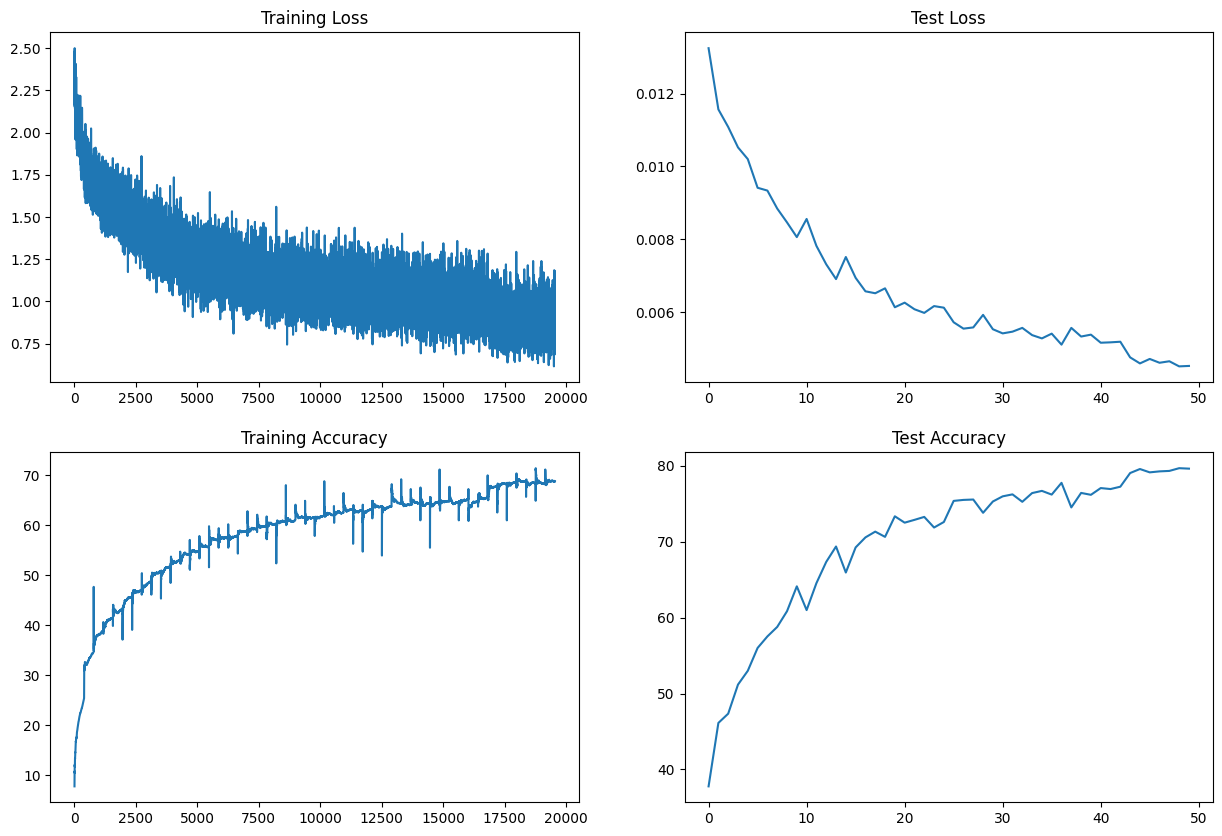

In [14]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)


# Dilated Kernels implementation

In [20]:
class Net(nn.Module):
    def __init__(self,dp_rate):
        super(Net,self).__init__()
        self.dp_rate = dp_rate
    
        self.c1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=12,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=12,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
        )

        self.c2 = nn.Sequential(
            ConvLayer(inc=16,outc=24,k=3,p=1,d=1,s=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=24,k=3,p=0,s=1,d=1,dp_rate=self.dp_rate)
        )
        self.c3DiL = nn.Sequential(
            ConvLayer(inc=16,outc=24,s=1,p=1,d=2,k=3,dp_rate=self.dp_rate),
        )


        self.c4 = nn.Sequential(
            ConvLayer(inc=24,outc=30,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=30,outc=30,k=3,p=0,s=1,d=1,dp_rate=self.dp_rate),
        )


        self.c5DiL = nn.Sequential(
            ConvLayer(inc=24,outc=30,k=3,d=2,p=1,dp_rate=self.dp_rate,s=1)
        )

        self.c6 = nn.Sequential(
            ConvLayer(inc=30,outc=32,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=32,outc=36,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=36,outc=38,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1),
            ConvLayer(inc=38,outc=40,k=3,p=0,dp_rate=self.dp_rate,s=1,d=1)
        )

        self.C7DiL = nn.Sequential(
            ConvLayer(inc=30,outc=36,k=3,p=0,dp_rate=self.dp_rate,s=1,d=2),
            ConvLayer(inc=36,outc=40,k=3,p=0,dp_rate=self.dp_rate,s=1,d=2)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(in_channels=40,out_channels=10,kernel_size=1,bias=False)
    
    def forward(self,x):

        # BLOCK ONE
        x = self.c1(x)
        path1 = self.c2(x)
        path2 = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.c3DiL(x),
                            torch.zeros(24,device=device), #mu=0
                            torch.ones(24,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ) # self.c3DiL(x)
                )
        x = path1 + path2

        # BLOCK TWO
        path1 = self.c4(x)
        path2 = F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.c5DiL(x),
                            torch.zeros(30,device=device), #mu=0
                            torch.ones(30,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ) # self.c3DiL(x)
                )
        x = path1+path2 

        # BLOCK 4
        path1 = self.c6(x)
        path2  =F.dropout2d(
                    F.relu_( 
                        F.batch_norm(
                            self.C7DiL(x),
                            torch.zeros(40,device=device), #mu=0
                            torch.ones(40,device=device),   # ones are fine for first training iter  
                            training=True,
                            momentum=0.9
                        )
                    ) # self.c3DiL(x)
                )
        x = path1 + path2

        # GAP
        x = self.gap(x)

        # OUT BLOCK
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [21]:
model3 = Net(0.1).to(device)
summary(model3,(1,3,32,32),)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─ConvLayer: 2-1                    [1, 8, 32, 32]            --
│    │    └─Sequential: 3-1              [1, 8, 32, 32]            232
│    └─ConvLayer: 2-2                    [1, 12, 32, 32]           --
│    │    └─Sequential: 3-2              [1, 12, 32, 32]           888
│    └─ConvLayer: 2-3                    [1, 16, 32, 32]           --
│    │    └─Sequential: 3-3              [1, 16, 32, 32]           1,760
├─Sequential: 1-2                        [1, 24, 30, 30]           --
│    └─ConvLayer: 2-4                    [1, 24, 32, 32]           --
│    │    └─Sequential: 3-4              [1, 24, 32, 32]           3,504
│    └─ConvLayer: 2-5                    [1, 24, 30, 30]           --
│    │    └─Sequential: 3-5              [1, 24, 30, 30]           5,232
├─Se

In [22]:
prev_test_loss = float('inf')


optimizer = optim.SGD(model3.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model3, simple_train_loader, optimizer, criterion, device)
tester = Tester(model3, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model3.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_with_dilation_kernel.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.98 | Batch = 390 | Accuracy = 19.42: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.64it/s]


Test set: Average loss: 0.0152, Accuracy: 2393/10000 (23.93%)


EPOCH = 2 | LR = 0.1 | Loss = 1.79 | Batch = 390 | Accuracy = 24.92: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.95it/s]


Test set: Average loss: 0.0143, Accuracy: 2792/10000 (27.92%)


EPOCH = 3 | LR = 0.1 | Loss = 1.77 | Batch = 390 | Accuracy = 29.03: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.96it/s]


Test set: Average loss: 0.0139, Accuracy: 3215/10000 (32.15%)


EPOCH = 4 | LR = 0.1 | Loss = 1.83 | Batch = 390 | Accuracy = 31.54: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.95it/s]


Test set: Average loss: 0.0133, Accuracy: 3556/10000 (35.56%)


EPOCH = 5 | LR = 0.1 | Loss = 1.68 | Batch = 390 | Accuracy = 33.42: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.93it/s]


Test set: Average loss: 0.0131, Accuracy: 3775/10000 (37.75%)


EPOCH = 6 | LR = 0.1 | Loss = 1.59 | Batch = 390 | Accuracy = 35.71: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.91it/s]


Test set: Average loss: 0.0123, Accuracy: 4120/10000 (41.20%)


EPOCH = 7 | LR = 0.1 | Loss = 1.63 | Batch = 390 | Accuracy = 37.70: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.96it/s]


Test set: Average loss: 0.0118, Accuracy: 4508/10000 (45.08%)


EPOCH = 8 | LR = 0.1 | Loss = 1.75 | Batch = 390 | Accuracy = 39.91: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.93it/s]


Test set: Average loss: 0.0115, Accuracy: 4618/10000 (46.18%)


EPOCH = 9 | LR = 0.1 | Loss = 1.45 | Batch = 390 | Accuracy = 41.82: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.93it/s]


Test set: Average loss: 0.0115, Accuracy: 4611/10000 (46.11%)


EPOCH = 10 | LR = 0.1 | Loss = 1.68 | Batch = 390 | Accuracy = 43.53: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.95it/s]


Test set: Average loss: 0.0108, Accuracy: 5023/10000 (50.23%)


EPOCH = 11 | LR = 0.1 | Loss = 1.42 | Batch = 390 | Accuracy = 45.37: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.92it/s]


Test set: Average loss: 0.0106, Accuracy: 5048/10000 (50.48%)


EPOCH = 12 | LR = 0.1 | Loss = 1.38 | Batch = 390 | Accuracy = 46.53: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.90it/s]


Test set: Average loss: 0.0103, Accuracy: 5306/10000 (53.06%)


EPOCH = 13 | LR = 0.1 | Loss = 1.58 | Batch = 390 | Accuracy = 47.65: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.84it/s]


Test set: Average loss: 0.0100, Accuracy: 5413/10000 (54.13%)


EPOCH = 14 | LR = 0.1 | Loss = 1.39 | Batch = 390 | Accuracy = 49.17: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.91it/s]


Test set: Average loss: 0.0101, Accuracy: 5404/10000 (54.04%)


EPOCH = 15 | LR = 0.1 | Loss = 1.49 | Batch = 390 | Accuracy = 50.17: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.91it/s]


Test set: Average loss: 0.0095, Accuracy: 5636/10000 (56.36%)


EPOCH = 16 | LR = 0.1 | Loss = 1.26 | Batch = 390 | Accuracy = 50.85: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.95it/s]


Test set: Average loss: 0.0094, Accuracy: 5705/10000 (57.05%)


EPOCH = 17 | LR = 0.1 | Loss = 1.03 | Batch = 390 | Accuracy = 51.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.89it/s]


Test set: Average loss: 0.0091, Accuracy: 5835/10000 (58.35%)


EPOCH = 18 | LR = 0.1 | Loss = 1.27 | Batch = 390 | Accuracy = 52.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:30<00:00, 12.88it/s]


Test set: Average loss: 0.0090, Accuracy: 5865/10000 (58.65%)


EPOCH = 19 | LR = 0.1 | Loss = 1.21 | Batch = 390 | Accuracy = 53.05: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.28it/s]


Test set: Average loss: 0.0091, Accuracy: 5783/10000 (57.83%)


EPOCH = 20 | LR = 0.1 | Loss = 1.08 | Batch = 390 | Accuracy = 53.87: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.44it/s]


Test set: Average loss: 0.0089, Accuracy: 5898/10000 (58.98%)


EPOCH = 21 | LR = 0.1 | Loss = 1.33 | Batch = 390 | Accuracy = 54.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.44it/s]


Test set: Average loss: 0.0087, Accuracy: 5997/10000 (59.97%)


EPOCH = 22 | LR = 0.1 | Loss = 1.29 | Batch = 390 | Accuracy = 54.63: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.46it/s]


Test set: Average loss: 0.0087, Accuracy: 6128/10000 (61.28%)


EPOCH = 23 | LR = 0.1 | Loss = 1.51 | Batch = 390 | Accuracy = 55.49: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.34it/s]


Test set: Average loss: 0.0083, Accuracy: 6223/10000 (62.23%)


EPOCH = 24 | LR = 0.1 | Loss = 1.24 | Batch = 390 | Accuracy = 55.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:32<00:00, 12.19it/s]


Test set: Average loss: 0.0084, Accuracy: 6215/10000 (62.15%)


EPOCH = 25 | LR = 0.1 | Loss = 1.20 | Batch = 390 | Accuracy = 56.23: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.24it/s]


Test set: Average loss: 0.0081, Accuracy: 6331/10000 (63.31%)


EPOCH = 26 | LR = 0.1 | Loss = 1.17 | Batch = 390 | Accuracy = 56.80: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.57it/s]


Test set: Average loss: 0.0081, Accuracy: 6372/10000 (63.72%)


EPOCH = 27 | LR = 0.1 | Loss = 1.18 | Batch = 390 | Accuracy = 56.87: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.56it/s]


Test set: Average loss: 0.0084, Accuracy: 6135/10000 (61.35%)


EPOCH = 28 | LR = 0.1 | Loss = 1.19 | Batch = 390 | Accuracy = 57.39: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.56it/s]


Test set: Average loss: 0.0081, Accuracy: 6380/10000 (63.80%)


EPOCH = 29 | LR = 0.1 | Loss = 1.22 | Batch = 390 | Accuracy = 58.22: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.58it/s]


Test set: Average loss: 0.0080, Accuracy: 6430/10000 (64.30%)


EPOCH = 30 | LR = 0.1 | Loss = 1.05 | Batch = 390 | Accuracy = 57.97: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.58it/s]


Test set: Average loss: 0.0081, Accuracy: 6292/10000 (62.92%)


EPOCH = 31 | LR = 0.1 | Loss = 1.32 | Batch = 390 | Accuracy = 58.37: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.39it/s]


Test set: Average loss: 0.0079, Accuracy: 6453/10000 (64.53%)


EPOCH = 32 | LR = 0.1 | Loss = 1.10 | Batch = 390 | Accuracy = 58.80: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.57it/s]


Test set: Average loss: 0.0078, Accuracy: 6439/10000 (64.39%)


EPOCH = 33 | LR = 0.1 | Loss = 1.32 | Batch = 390 | Accuracy = 58.74: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.58it/s]


Test set: Average loss: 0.0079, Accuracy: 6386/10000 (63.86%)


EPOCH = 34 | LR = 0.1 | Loss = 1.19 | Batch = 390 | Accuracy = 59.30: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.60it/s]


Test set: Average loss: 0.0076, Accuracy: 6532/10000 (65.32%)


EPOCH = 35 | LR = 0.1 | Loss = 1.06 | Batch = 390 | Accuracy = 59.61: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.56it/s]


Test set: Average loss: 0.0077, Accuracy: 6479/10000 (64.79%)


EPOCH = 36 | LR = 0.1 | Loss = 1.21 | Batch = 390 | Accuracy = 59.54: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0078, Accuracy: 6410/10000 (64.10%)


EPOCH = 37 | LR = 0.1 | Loss = 1.18 | Batch = 390 | Accuracy = 59.77: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0077, Accuracy: 6475/10000 (64.75%)


EPOCH = 38 | LR = 0.1 | Loss = 1.20 | Batch = 390 | Accuracy = 60.22: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0076, Accuracy: 6559/10000 (65.59%)


EPOCH = 39 | LR = 0.1 | Loss = 0.90 | Batch = 390 | Accuracy = 60.28: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.56it/s]


Test set: Average loss: 0.0074, Accuracy: 6618/10000 (66.18%)


EPOCH = 40 | LR = 0.1 | Loss = 0.92 | Batch = 390 | Accuracy = 60.96: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0074, Accuracy: 6721/10000 (67.21%)


EPOCH = 41 | LR = 0.1 | Loss = 1.22 | Batch = 390 | Accuracy = 60.61: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.54it/s]


Test set: Average loss: 0.0074, Accuracy: 6639/10000 (66.39%)


EPOCH = 42 | LR = 0.1 | Loss = 1.31 | Batch = 390 | Accuracy = 61.36: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.56it/s]


Test set: Average loss: 0.0073, Accuracy: 6711/10000 (67.11%)


EPOCH = 43 | LR = 0.1 | Loss = 1.15 | Batch = 390 | Accuracy = 61.19: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0073, Accuracy: 6733/10000 (67.33%)


EPOCH = 44 | LR = 0.1 | Loss = 1.24 | Batch = 390 | Accuracy = 61.46: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.36it/s]


Test set: Average loss: 0.0073, Accuracy: 6691/10000 (66.91%)


EPOCH = 45 | LR = 0.1 | Loss = 1.04 | Batch = 390 | Accuracy = 61.54: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.52it/s]


Test set: Average loss: 0.0073, Accuracy: 6733/10000 (67.33%)


EPOCH = 46 | LR = 0.1 | Loss = 1.00 | Batch = 390 | Accuracy = 61.82: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0070, Accuracy: 6851/10000 (68.51%)


EPOCH = 47 | LR = 0.1 | Loss = 0.95 | Batch = 390 | Accuracy = 61.92: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.56it/s]


Test set: Average loss: 0.0073, Accuracy: 6648/10000 (66.48%)


EPOCH = 48 | LR = 0.1 | Loss = 0.86 | Batch = 390 | Accuracy = 62.10: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.55it/s]


Test set: Average loss: 0.0073, Accuracy: 6723/10000 (67.23%)


EPOCH = 49 | LR = 0.1 | Loss = 1.05 | Batch = 390 | Accuracy = 62.06: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.50it/s]


Test set: Average loss: 0.0070, Accuracy: 6817/10000 (68.17%)


EPOCH = 50 | LR = 0.1 | Loss = 1.03 | Batch = 390 | Accuracy = 62.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:31<00:00, 12.53it/s]


Test set: Average loss: 0.0071, Accuracy: 6756/10000 (67.56%)


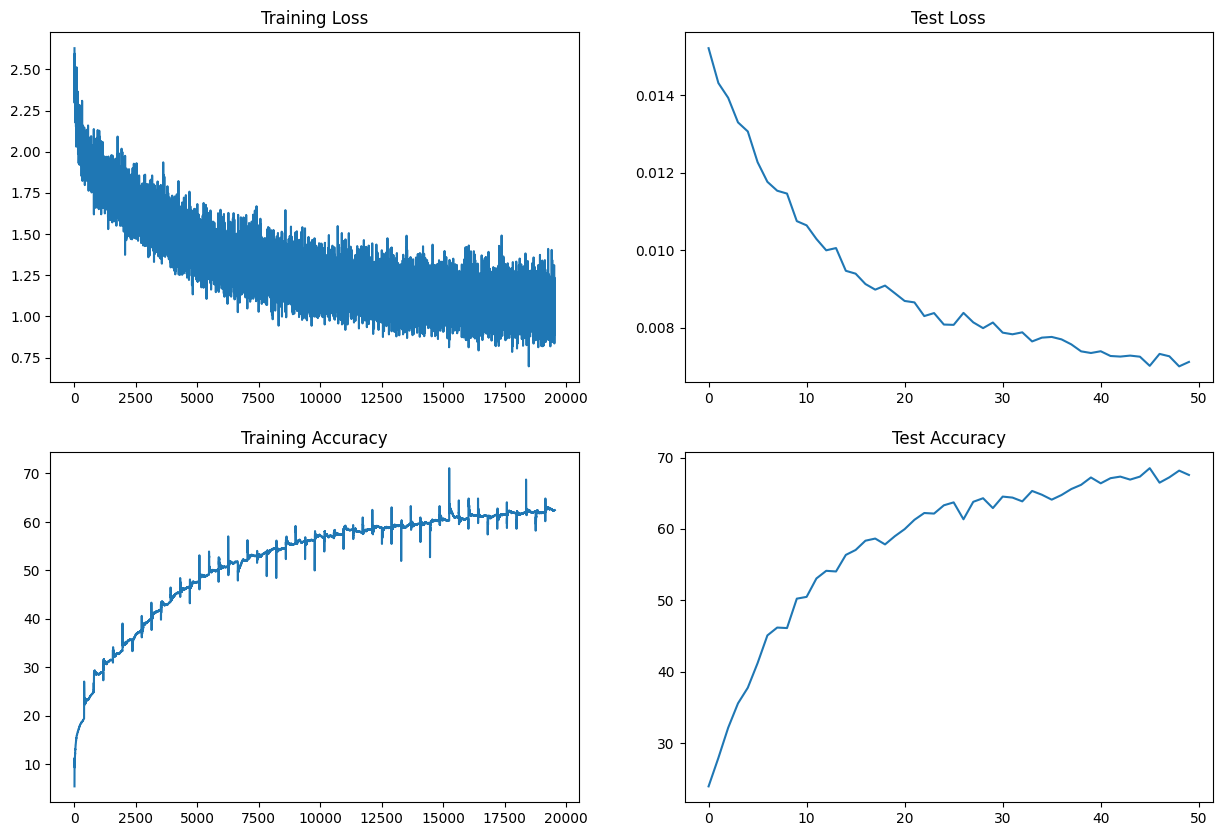

In [23]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [ ]:
model4 = Net(0.2).to(device)
summary(model4,(1,3,32,32),)


prev_test_loss = float('inf')


optimizer = optim.SGD(model4.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model4, train_loader, optimizer, criterion, device)
tester = Tester(model4, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(model3.state_dict(),'./bmodels/simple_model_with_mp_rf44_resnet_with_dilation_kernel_aug.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 2.15 | Batch = 390 | Accuracy = 15.45: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.06it/s]


Test set: Average loss: 0.0169, Accuracy: 2083/10000 (20.83%)


EPOCH = 2 | LR = 0.1 | Loss = 2.10 | Batch = 390 | Accuracy = 18.49: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.35it/s]


Test set: Average loss: 0.0164, Accuracy: 2073/10000 (20.73%)


EPOCH = 3 | LR = 0.1 | Loss = 2.19 | Batch = 390 | Accuracy = 19.10: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:34<00:00, 11.37it/s]


Test set: Average loss: 0.0163, Accuracy: 2155/10000 (21.55%)


EPOCH = 4 | LR = 0.1 | Loss = 2.24 | Batch = 390 | Accuracy = 19.78: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Test set: Average loss: 0.0161, Accuracy: 2232/10000 (22.32%)


EPOCH = 5 | LR = 0.1 | Loss = 1.95 | Batch = 390 | Accuracy = 20.45: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Test set: Average loss: 0.0159, Accuracy: 2537/10000 (25.37%)


EPOCH = 6 | LR = 0.1 | Loss = 2.08 | Batch = 390 | Accuracy = 21.23: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Test set: Average loss: 0.0156, Accuracy: 2492/10000 (24.92%)


EPOCH = 7 | LR = 0.1 | Loss = 2.03 | Batch = 390 | Accuracy = 22.21: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Test set: Average loss: 0.0153, Accuracy: 2805/10000 (28.05%)


EPOCH = 8 | LR = 0.1 | Loss = 2.31 | Batch = 390 | Accuracy = 22.67: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.69it/s]


Test set: Average loss: 0.0151, Accuracy: 2819/10000 (28.19%)


EPOCH = 9 | LR = 0.1 | Loss = 1.93 | Batch = 390 | Accuracy = 23.60: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.69it/s]


Test set: Average loss: 0.0148, Accuracy: 3004/10000 (30.04%)


EPOCH = 10 | LR = 0.1 | Loss = 2.09 | Batch = 390 | Accuracy = 23.97: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.54it/s]


Test set: Average loss: 0.0145, Accuracy: 3135/10000 (31.35%)


EPOCH = 11 | LR = 0.1 | Loss = 2.04 | Batch = 390 | Accuracy = 25.24: 100%|████████████████████████████████████████████████████████████| 391/391 [09:56<00:00,  1.52s/it]


Test set: Average loss: 0.0145, Accuracy: 3012/10000 (30.12%)


EPOCH = 12 | LR = 0.1 | Loss = 1.91 | Batch = 390 | Accuracy = 25.35: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Test set: Average loss: 0.0142, Accuracy: 3184/10000 (31.84%)


EPOCH = 13 | LR = 0.1 | Loss = 1.82 | Batch = 390 | Accuracy = 26.16: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.57it/s]


Test set: Average loss: 0.0138, Accuracy: 3294/10000 (32.94%)


EPOCH = 14 | LR = 0.1 | Loss = 1.92 | Batch = 390 | Accuracy = 26.83: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.63it/s]


Test set: Average loss: 0.0138, Accuracy: 3433/10000 (34.33%)


EPOCH = 15 | LR = 0.1 | Loss = 1.73 | Batch = 390 | Accuracy = 27.14: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Test set: Average loss: 0.0137, Accuracy: 3388/10000 (33.88%)


EPOCH = 16 | LR = 0.1 | Loss = 2.14 | Batch = 390 | Accuracy = 27.64: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Test set: Average loss: 0.0135, Accuracy: 3573/10000 (35.73%)


EPOCH = 17 | LR = 0.1 | Loss = 1.98 | Batch = 390 | Accuracy = 28.18: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.69it/s]


Test set: Average loss: 0.0135, Accuracy: 3504/10000 (35.04%)


EPOCH = 18 | LR = 0.1 | Loss = 1.83 | Batch = 390 | Accuracy = 28.63: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.67it/s]


Test set: Average loss: 0.0135, Accuracy: 3582/10000 (35.82%)


EPOCH = 19 | LR = 0.1 | Loss = 1.71 | Batch = 390 | Accuracy = 28.90: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.59it/s]


Test set: Average loss: 0.0134, Accuracy: 3564/10000 (35.64%)


EPOCH = 20 | LR = 0.1 | Loss = 2.00 | Batch = 390 | Accuracy = 29.00: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.65it/s]


Test set: Average loss: 0.0131, Accuracy: 3738/10000 (37.38%)


EPOCH = 21 | LR = 0.1 | Loss = 1.79 | Batch = 390 | Accuracy = 29.29: 100%|████████████████████████████████████████████████████████████| 391/391 [00:33<00:00, 11.66it/s]


Test set: Average loss: 0.0132, Accuracy: 3759/10000 (37.59%)


EPOCH = 22 | LR = 0.1 | Loss = 1.82 | Batch = 390 | Accuracy = 30.14: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 10.99it/s]


Test set: Average loss: 0.0131, Accuracy: 3789/10000 (37.89%)


EPOCH = 23 | LR = 0.1 | Loss = 1.80 | Batch = 390 | Accuracy = 30.16: 100%|████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.74it/s]


Test set: Average loss: 0.0132, Accuracy: 3849/10000 (38.49%)


EPOCH = 24 | LR = 0.1 | Loss = 1.92 | Batch = 390 | Accuracy = 30.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


Test set: Average loss: 0.0131, Accuracy: 3756/10000 (37.56%)


EPOCH = 25 | LR = 0.1 | Loss = 1.71 | Batch = 390 | Accuracy = 30.89: 100%|████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.76it/s]


Test set: Average loss: 0.0130, Accuracy: 3803/10000 (38.03%)


EPOCH = 26 | LR = 0.1 | Loss = 1.79 | Batch = 390 | Accuracy = 30.86: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.10it/s]


Test set: Average loss: 0.0128, Accuracy: 3903/10000 (39.03%)


EPOCH = 27 | LR = 0.1 | Loss = 1.77 | Batch = 390 | Accuracy = 30.87: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 10.94it/s]


Test set: Average loss: 0.0130, Accuracy: 3884/10000 (38.84%)


EPOCH = 28 | LR = 0.1 | Loss = 1.63 | Batch = 390 | Accuracy = 31.72: 100%|████████████████████████████████████████████████████████████| 391/391 [00:36<00:00, 10.77it/s]


Test set: Average loss: 0.0127, Accuracy: 3990/10000 (39.90%)


EPOCH = 29 | LR = 0.1 | Loss = 1.91 | Batch = 390 | Accuracy = 31.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.00it/s]


Test set: Average loss: 0.0126, Accuracy: 4098/10000 (40.98%)


EPOCH = 30 | LR = 0.1 | Loss = 1.70 | Batch = 390 | Accuracy = 32.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.02it/s]


Test set: Average loss: 0.0125, Accuracy: 4092/10000 (40.92%)


EPOCH = 31 | LR = 0.1 | Loss = 1.89 | Batch = 390 | Accuracy = 32.07: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.03it/s]


Test set: Average loss: 0.0127, Accuracy: 4099/10000 (40.99%)


EPOCH = 32 | LR = 0.1 | Loss = 1.77 | Batch = 390 | Accuracy = 32.50: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 10.97it/s]


Test set: Average loss: 0.0126, Accuracy: 4056/10000 (40.56%)


EPOCH = 33 | LR = 0.1 | Loss = 1.65 | Batch = 390 | Accuracy = 32.79: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 10.98it/s]


Test set: Average loss: 0.0124, Accuracy: 4181/10000 (41.81%)


EPOCH = 34 | LR = 0.1 | Loss = 1.70 | Batch = 390 | Accuracy = 32.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.03it/s]


Test set: Average loss: 0.0123, Accuracy: 4230/10000 (42.30%)


EPOCH = 35 | LR = 0.1 | Loss = 1.77 | Batch = 390 | Accuracy = 33.05: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.02it/s]


Test set: Average loss: 0.0123, Accuracy: 4163/10000 (41.63%)


EPOCH = 36 | LR = 0.1 | Loss = 1.82 | Batch = 390 | Accuracy = 33.34: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 10.99it/s]


Test set: Average loss: 0.0122, Accuracy: 4228/10000 (42.28%)


EPOCH = 37 | LR = 0.1 | Loss = 1.86 | Batch = 390 | Accuracy = 33.08: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 10.99it/s]


Test set: Average loss: 0.0124, Accuracy: 4176/10000 (41.76%)


EPOCH = 38 | LR = 0.1 | Loss = 1.72 | Batch = 390 | Accuracy = 33.60: 100%|████████████████████████████████████████████████████████████| 391/391 [00:35<00:00, 11.00it/s]


Test set: Average loss: 0.0124, Accuracy: 4188/10000 (41.88%)


EPOCH = 39 | LR = 0.1 | Loss = 1.88 | Batch = 390 | Accuracy = 33.81: 100%|████████████████████████████████████████████████████████████| 391/391 [00:57<00:00,  6.77it/s]


Test set: Average loss: 0.0122, Accuracy: 4304/10000 (43.04%)


EPOCH = 40 | LR = 0.1 | Loss = 1.81 | Batch = 390 | Accuracy = 33.98: 100%|████████████████████████████████████████████████████████████| 391/391 [01:22<00:00,  4.75it/s]


Test set: Average loss: 0.0123, Accuracy: 4258/10000 (42.58%)


EPOCH = 41 | LR = 0.1 | Loss = 1.87 | Batch = 390 | Accuracy = 33.78: 100%|████████████████████████████████████████████████████████████| 391/391 [01:22<00:00,  4.77it/s]


Test set: Average loss: 0.0122, Accuracy: 4291/10000 (42.91%)


EPOCH = 42 | LR = 0.1 | Loss = 1.71 | Batch = 390 | Accuracy = 34.01: 100%|████████████████████████████████████████████████████████████| 391/391 [01:22<00:00,  4.75it/s]


Test set: Average loss: 0.0123, Accuracy: 4229/10000 (42.29%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 1.64 | Batch = 390 | Accuracy = 34.79: 100%|███████████████████████████████████████████| 391/391 [01:23<00:00,  4.70it/s]


Test set: Average loss: 0.0120, Accuracy: 4382/10000 (43.82%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 1.80 | Batch = 137 | Accuracy = 34.95:  35%|███████████████▏                           | 138/391 [00:29<00:53,  4.69it/s]


In [ ]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)